In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import Blip2Processor
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.manifold import TSNE
from data.custom_dataset import TxtImageTextDataset
import numpy as np

/root/miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
txt_path = '/repo/project_deepfake/identifying-fake-news-with-image-textual-and-graph-features/fakeddit_dataset/text/text.txt'
image_folder = '/repo/project_deepfake/identifying-fake-news-with-image-textual-and-graph-features/fakeddit_dataset/images'
device = 'cuda'
batch_size = 32
method = 'umap'

In [3]:

def flatten_images(image_tensor):
    """Convert [N, C, H, W] -> [N, C*H*W]"""
    N = image_tensor.shape[0]
    return image_tensor.view(N, -1).cpu().numpy()

def flatten_text(text_tensor):
    """Convert [N, seq_len] -> [N, seq_len]"""
    return text_tensor.cpu().numpy()


In [4]:
def visualize_embeddings(image_embs, text_embs, labels, method="umap", joint=False, title_prefix=""):
    """
    image_embs: torch tensor [N, 3, H, W]
    text_embs: torch tensor [N, seq_len]
    labels: torch tensor [N]
    method: "umap" or "tsne"
    joint: if True, concatenate image+text embeddings
    """
    # Flatten embeddings
    img_flat = flatten_images(image_embs)
    txt_flat = flatten_text(text_embs)
    
    if joint:
        emb_matrix = np.concatenate([img_flat, txt_flat], axis=1)
        title_prefix += " (Joint)"
    else:
        emb_matrix = img_flat
        title_prefix += " (Image Only)"

    # Reduce dimension
    if method.lower() == "umap":
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
        emb_2d = reducer.fit_transform(emb_matrix)
    elif method.lower() == "tsne":
        emb_2d = TSNE(
            n_components=2,
            perplexity=30,
            learning_rate='auto',
            init='random',
            random_state=42,
            max_iter=1000
        ).fit_transform(emb_matrix)
    else:
        raise ValueError(f"Unknown method {method}, choose 'umap' or 'tsne'")

    # Plot    
    labels_np = labels.cpu().numpy() if torch.is_tensor(labels) else np.array(labels)
    colors = np.array(["red" if l == 0 else "green" for l in labels_np])

    plt.figure(figsize=(8, 6))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, alpha=0.7)
    plt.title(f"{title_prefix} Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 598f27c5-555a-4d5f-8be3-61ec9c10d698)')' thrown while requesting HEAD https://huggingface.co/Salesforce/blip2-flan-t5-xl/resolve/main/audio_tokenizer_config.json
Retrying in 1s [Retry 1/5].


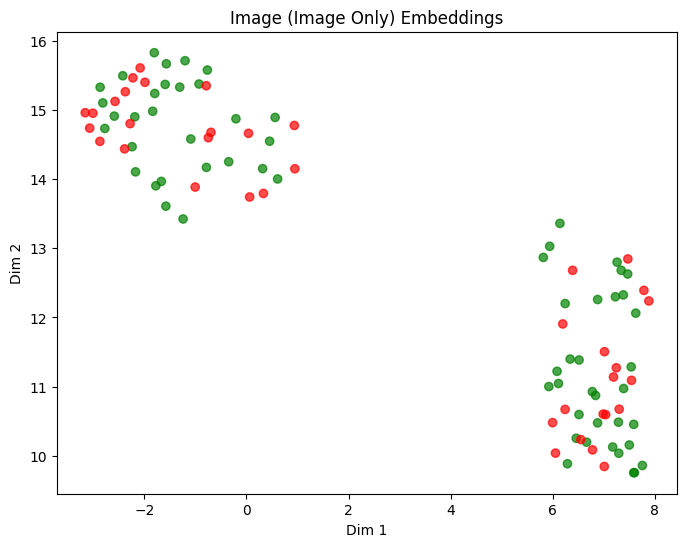

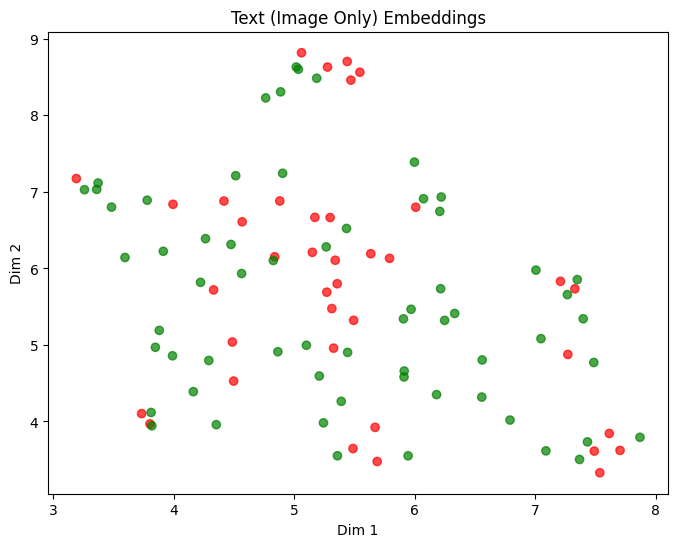

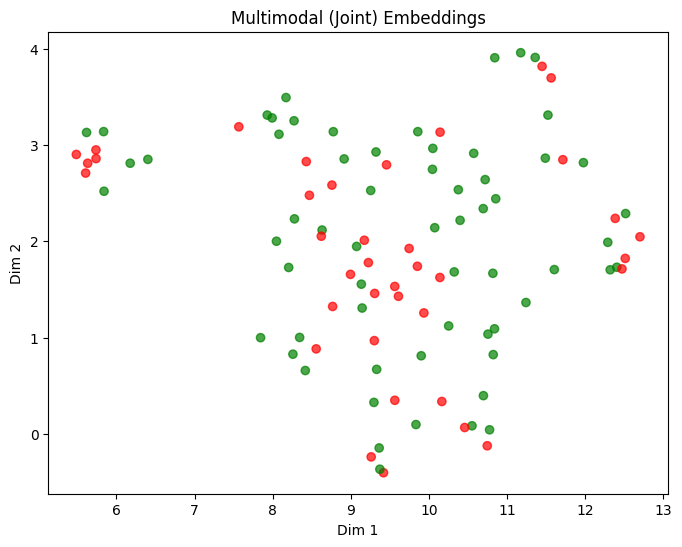

In [15]:
from torch.utils.data import DataLoader


processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
dataset = TxtImageTextDataset(txt_path, image_folder, processor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

all_image_embs, all_text_embs, all_labels = [], [], []

for image_tensor, text_tensor, labels in loader:
    all_image_embs.append(image_tensor)
    all_text_embs.append(text_tensor)
    all_labels.append(labels)

all_image_embs = torch.cat(all_image_embs)
all_text_embs = torch.cat(all_text_embs)
all_labels = torch.cat(all_labels)

# Image-only UMAP
visualize_embeddings(all_image_embs, all_text_embs, all_labels, method="umap", joint=False, title_prefix="Image")

# Text-only UMAP
visualize_embeddings(all_text_embs, all_text_embs, all_labels, method="umap", joint=False, title_prefix="Text")

# Joint image+text UMAP
visualize_embeddings(all_image_embs, all_text_embs, all_labels, method="umap", joint=True, title_prefix="Multimodal")


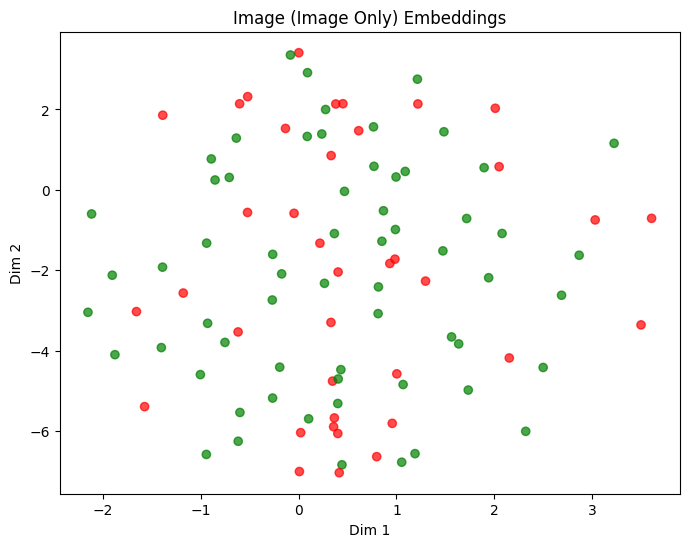

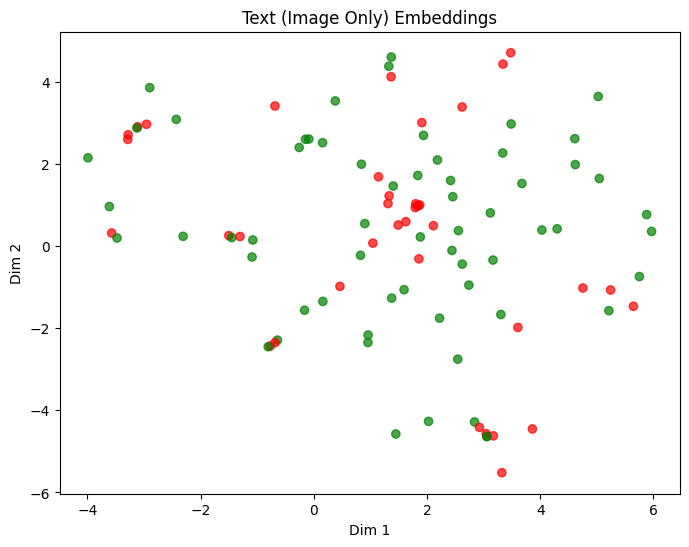

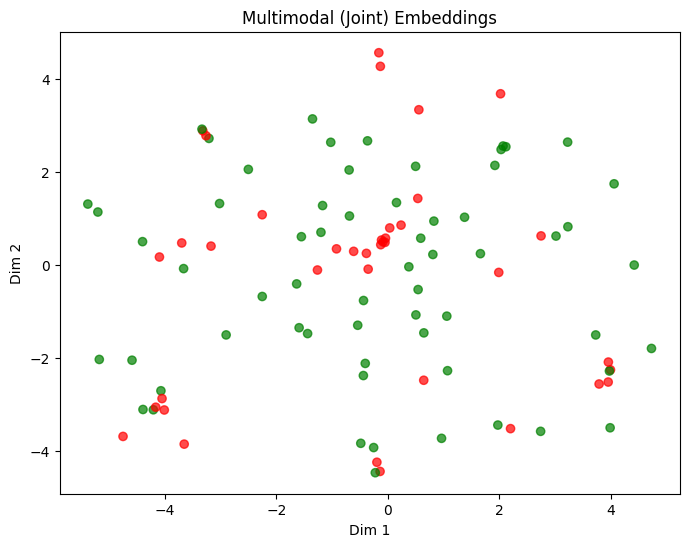

In [18]:
# Image-only T-SNE
visualize_embeddings(all_image_embs, all_text_embs, all_labels, method="tsne", joint=False, title_prefix="Image")

# Text-only T-SNE
visualize_embeddings(all_text_embs, all_text_embs, all_labels, method="tsne", joint=False, title_prefix="Text")

# Joint image+text T-SNE
visualize_embeddings(all_image_embs, all_text_embs, all_labels, method="tsne", joint=True, title_prefix="Multimodal")
